# Ejercicio 2¶

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

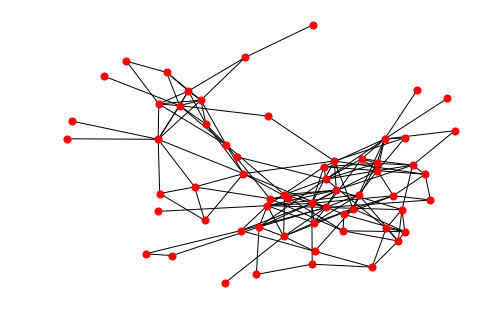

In [3]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=50)
plt.show()
#list(G)

In [4]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')

data_gender
colores=[]

#le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
#creamos un vector de colores que vincula los generos (mismo orden)     
for gen in nx.get_node_attributes(G, "genero").values():
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')
        


In [5]:
#verificamos el vector colores
#nx.get_node_attributes(G, "genero").values()

### Asi se accede a las propiedades de un nodo:
#G.node['Ripplefluke']

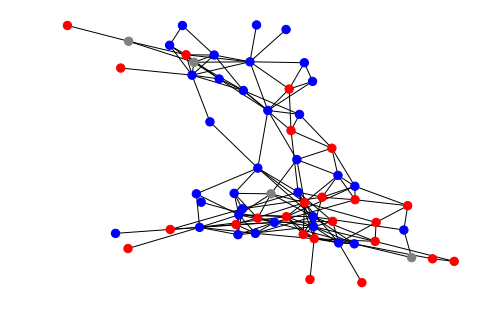

In [6]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=70,node_grouping='genero')
plt.show()

In [47]:
def delta_kronecker(x,y):
    resultado=0
    if x==y:
        resultado=1
    return resultado
    

In [68]:
def modularity(G):
    A = nx.adjacency_matrix(G)  # Matriz de adycencia
    m = G.number_of_edges()
    v=0
    sumando = 0.0
    for node_v in G:
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        kv= list(G.degree)[v][1]
        w=0
        for node_w in G:
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if( delta_kronecker(genero_v,genero_w)):
                kw= list(G.degree)[w][1]
                A_vw = A[v,w]
                sumando += A_vw-(kv*kw)/(2.0*m)
            w+=1
        v+=1
    Q = sumando/(2.0*m)
    return round(Q,3)
modularity(G)

-0.023

In [73]:
nodes = nx.get_node_attributes(G, "genero").values()
modularity_data=modularity(G)
array_Q = []
iter_max = 20
iteracion=0
while iteracion<iter_max:
    random.shuffle(nodes)
    i=0
    for n in G:
        G.node[n]['genero']= nodes[i]
        i+=1
    array_Q +=[modularity(G)]
    iteracion+=1
print(np.mean(array_Q))
print(modularity_data)

-0.015750000000000004
0.038
